<img src=logo.png>

* ref: https://www.kaggle.com/c/digit-recognizer/overview  
❕ csv -> arr

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- visualization (edcoding, grid) -----------

import matplotlib.pyplot as plt
import seaborn as sns

#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# sns.set()


In [2]:
# ------------- tensorflow & keras -----------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation                 #-------------FC
from keras.layers import Conv2D, MaxPooling2D,Flatten      #-------------CNN
from keras.preprocessing.image import ImageDataGenerator   #-------------Augmentation
from keras.preprocessing.image import array_to_img, img_to_array, load_img # ㄴ flow



from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint  #------------ callback

# --------------------- etc. -----------------------
from PIL import Image


# ----------------- fixing seed --------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [3]:
# colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Dataload

In [ ]:
# jupyter
# train = pd.read_csv('dataset/train.csv')
# test = pd.read_csv('dataset/test.csv')
# sub = pd.read_csv('dataset/sample_submission.csv')

FileNotFoundError: ignored

In [4]:
# colab 
train = pd.read_csv('/content/gdrive/MyDrive/digit_k/dataset/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/digit_k/dataset/test.csv')
sub = pd.read_csv('/content/gdrive/MyDrive/digit_k/dataset/sample_submission.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [ ]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 437.6 KB


# Data pre-processing

## X_train_arr, y_train_arr, X_test_arr

In [5]:
X=train.drop('label', axis=1)
y=train['label']

In [6]:
X_train_arr=np.array(X)
y_train_arr=np.array(y)

X_test_arr=np.array(test)

In [7]:
X_train_arr.shape, X_test_arr.shape, y_train_arr.shape # X_train is already flattened

((42000, 784), (28000, 784), (42000,))

# EDA

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


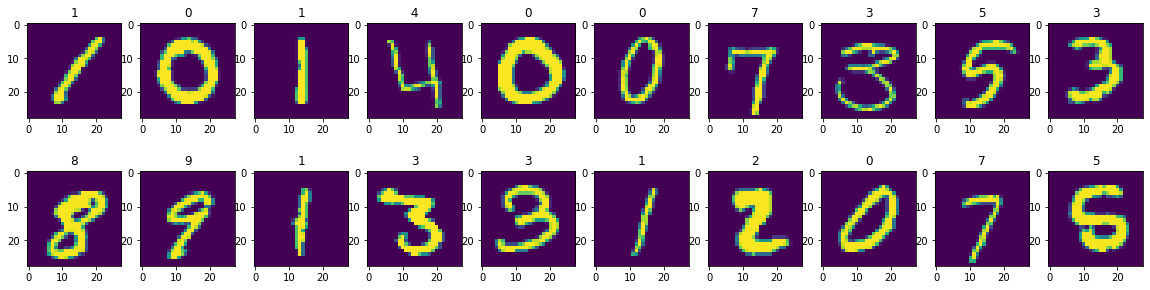

In [ ]:
X_train_arr_img=X_train_arr.reshape(42000,28,28)

f, axes = plt.subplots(2,10, figsize=(20,5))

for i, arr in enumerate(X_train_arr_img[:20]):
    r=i//10
    c=i%10
    
    axes[r,c].imshow(arr)
    axes[r,c].set_title(y_train_arr[i])
    
plt.show()

# to_categorical y
y_label : integers in range 0-9

In [8]:
y_train_arr=to_categorical(y=y_train_arr, num_classes=10, dtype='int32')

# train Model

In [ ]:
model=Sequential()

model.add(Dense(units=64 , activation='relu',input_shape=(28*28,)))
model.add(Dense(units=32 , activation='relu'))
model.add(Dense(units=24 , activation='relu'))
model.add(Dense(units=32 , activation='relu'))
model.add(Dense(units=17 , activation='relu'))
model.add(Dense(units=16 , activation='relu'))
model.add(Dense(units=10 , activation='softmax')) # multi-classification

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                50176     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 24)                792       
                                                                 
 dense_17 (Dense)            (None, 32)                800       
                                                                 
 dense_18 (Dense)            (None, 17)                561       
                                                                 
 dense_19 (Dense)            (None, 16)                288       
                                                                 
 dense_20 (Dense)            (None, 10)               

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics='accuracy')

# prediciton
leaderboard: 0.95803

# Additional featuring -> delete before task(sub_v02, v03) and rescale & make val dataset
leaderboard: 0.96096

In [9]:
X_train_arr_scaled=X_train_arr/255.0
X_test_arr_scaled=X_test_arr/255.0

## split train data into train & val data

In [10]:
X_train_arr_scaled_train=X_train_arr_scaled[:-4000]
X_train_arr_scaled_val=X_train_arr_scaled[-4000:]

y_train_arr_train=y_train_arr[:-4000]
y_train_arr_val=y_train_arr[-4000:]

# CNN
leaderboard
epochs(15) : 0.98642  
epochs(3) : 0.98532

## reshape -> (data, H, W, Channel)

In [11]:
X_train_arr_scaled_train.shape, X_train_arr_scaled_val.shape, X_test_arr_scaled.shape

((38000, 784), (4000, 784), (28000, 784))

In [12]:
X_train_cnn=X_train_arr_scaled_train.reshape(-1, 28, 28, 1)
X_val_cnn=X_train_arr_scaled_val.reshape(-1, 28, 28, 1)
X_test_cnn=X_test_arr_scaled.reshape(-1, 28, 28, 1)

In [ ]:
y_train_arr_train.shape, y_train_arr_val.shape

((38000, 10), (4000, 10))

## Model

In [ ]:
input_shape = (28,28,1)
num_class = 10

model = Sequential([
                    Conv2D(32, kernel_size = (4,4), input_shape = input_shape, activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Flatten(),
                    Dense(32, activation = 'relu'),
                    Dense(10, activation = 'softmax')
                    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = 'accuracy')

In [ ]:
res = model.fit(X_train_cnn, y_train_arr_train,
                epochs = 15,
                batch_size = 10,
                validation_split = 0.2)

Epoch 1/15
3040/3040 [==============================] - 43s 14ms/step - loss: 0.0802 - accuracy: 0.9756 - val_loss: 0.0590 - val_accuracy: 0.9828
Epoch 2/15
3040/3040 [==============================] - 42s 14ms/step - loss: 0.0508 - accuracy: 0.9855 - val_loss: 0.0495 - val_accuracy: 0.9879
Epoch 3/15
3040/3040 [==============================] - 42s 14ms/step - loss: 0.0431 - accuracy: 0.9888 - val_loss: 0.0566 - val_accuracy: 0.9861
Epoch 4/15
3040/3040 [==============================] - 41s 14ms/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 0.0519 - val_accuracy: 0.9874
Epoch 5/15
3040/3040 [==============================] - 41s 14ms/step - loss: 0.0295 - accuracy: 0.9926 - val_loss: 0.0644 - val_accuracy: 0.9882
Epoch 6/15
3040/3040 [==============================] - 42s 14ms/step - loss: 0.0264 - accuracy: 0.9936 - val_loss: 0.0703 - val_accuracy: 0.9879
Epoch 7/15
3040/3040 [==============================] - 45s 15ms/step - loss: 0.0230 - accuracy: 0.9943 - val_loss: 0.0572 -

In [ ]:
loss, accuracy = model.evaluate(X_val_cnn, y_train_arr_val)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

125/125 [==============================] - 1s 9ms/step - loss: 0.0920 - accuracy: 0.9885
Loss = 0.09195
Accuracy = 0.98850


## Check overfitting

In [ ]:
# res.history

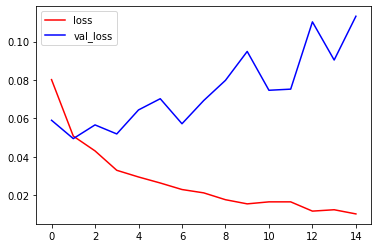

In [ ]:
plt.plot(range(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(range(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

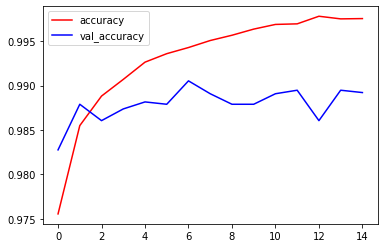

In [ ]:
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='accuracy')
plt.plot(np.arange(len(res.history['val_accuracy'])), res.history['val_accuracy'], c='blue', label='val_accuracy')
plt.legend()
plt.show()

## prediciton

In [ ]:
pred=model.predict(X_test_cnn)

In [ ]:
pred_list=[]
for arr in pred:
    pred_list.append(np.argmax(arr))

In [ ]:
pred_s=pd.Series(pred_list)
sub['Label']=pred_s

In [ ]:
# sub.to_csv('/content/gdrive/MyDrive/digit_k/dataset/sub_v05_of.csv', index=False)

## Model - to resolve overfitting problem -> reduce epoch

In [ ]:
input_shape = (28,28,1)
num_class = 10

model = Sequential([
                    Conv2D(32, kernel_size = (4,4), input_shape = input_shape, activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Flatten(),
                    Dense(32, activation = 'relu'),
                    Dense(10, activation = 'softmax')
                    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = 'accuracy')

In [ ]:
res = model.fit(X_train_cnn, y_train_arr_train,
                epochs = 3,
                batch_size = 10,
                validation_split = 0.2)

Epoch 1/3
3040/3040 [==============================] - 48s 15ms/step - loss: 0.1695 - accuracy: 0.9484 - val_loss: 0.0595 - val_accuracy: 0.9825
Epoch 2/3
3040/3040 [==============================] - 44s 14ms/step - loss: 0.0584 - accuracy: 0.9824 - val_loss: 0.0457 - val_accuracy: 0.9887
Epoch 3/3
3040/3040 [==============================] - 40s 13ms/step - loss: 0.0447 - accuracy: 0.9878 - val_loss: 0.0500 - val_accuracy: 0.9876


In [ ]:
loss, accuracy = model.evaluate(X_val_cnn, y_train_arr_val)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

125/125 [==============================] - 1s 9ms/step - loss: 0.0433 - accuracy: 0.9868
Loss = 0.04330
Accuracy = 0.98675


## Check overfitting

In [ ]:
# res.history

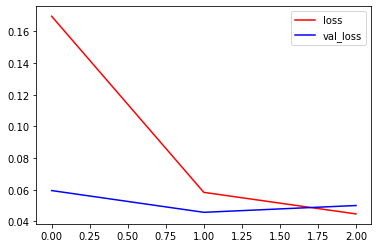

In [ ]:
plt.plot(range(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(range(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

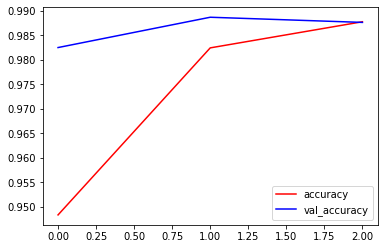

In [ ]:
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='accuracy')
plt.plot(np.arange(len(res.history['val_accuracy'])), res.history['val_accuracy'], c='blue', label='val_accuracy')
plt.legend()
plt.show()

## prediciton

In [ ]:
pred=model.predict(X_test_cnn)

In [ ]:
pred_list=[]
for arr in pred:
    pred_list.append(np.argmax(arr))

In [ ]:
pred_s=pd.Series(pred_list)
sub['Label']=pred_s

In [ ]:
# sub.to_csv('/content/gdrive/MyDrive/digit_k/dataset/sub_v05_not_of.csv', index=False)

# Augmentaion
leaderboard: Score: 0.98953

In [13]:
input_shape = (28,28,1)
num_class = 10

model = Sequential([Conv2D(32, kernel_size = (6,6), input_shape = input_shape, activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Conv2D(32, kernel_size = (4,4), input_shape = input_shape, activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Flatten(),
                    Dense(32, activation = 'relu'),
                    Dense(10, activation = 'softmax')
                    ])

In [14]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = 'accuracy')

In [15]:
X_aug = np.concatenate((X_train_cnn, X_val_cnn))
y_aug = np.concatenate((y_train_arr_train, y_train_arr_val))
X_aug.shape, y_aug.shape

((42000, 28, 28, 1), (42000, 10))

In [16]:
batch_size = 20

# train Augmentation Setting
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   validation_split = 0.2)

# train Augmentation
train_generator = train_datagen.flow(X_aug, y_aug,  
                                     batch_size = batch_size,
                                     subset = 'training')


val_generator = train_datagen.flow(X_aug, y_aug,  
                                 batch_size = batch_size,
                                 subset = 'validation')

In [17]:
res = model.fit(train_generator,
                steps_per_epoch = len(X_aug)*0.8/batch_size,
                epochs = 20,
                validation_data = val_generator,
                validation_steps = len(X_aug)*0.2/batch_size
                )

Epoch 1/20
1680/1680 [==============================] - 46s 27ms/step - loss: 0.2929 - accuracy: 0.9076 - val_loss: 0.0960 - val_accuracy: 0.9710
Epoch 2/20
1680/1680 [==============================] - 42s 25ms/step - loss: 0.0880 - accuracy: 0.9734 - val_loss: 0.0736 - val_accuracy: 0.9794
Epoch 3/20
1680/1680 [==============================] - 42s 25ms/step - loss: 0.0651 - accuracy: 0.9807 - val_loss: 0.0621 - val_accuracy: 0.9800
Epoch 4/20
1680/1680 [==============================] - 43s 26ms/step - loss: 0.0525 - accuracy: 0.9841 - val_loss: 0.0926 - val_accuracy: 0.9754
Epoch 5/20
1680/1680 [==============================] - 42s 25ms/step - loss: 0.0477 - accuracy: 0.9865 - val_loss: 0.0521 - val_accuracy: 0.9852
Epoch 6/20
1680/1680 [==============================] - 41s 25ms/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.0669 - val_accuracy: 0.9829
Epoch 7/20
1680/1680 [==============================] - 41s 25ms/step - loss: 0.0382 - accuracy: 0.9893 - val_loss: 0.0881 -

## Check overfitting

In [ ]:
# res.history

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


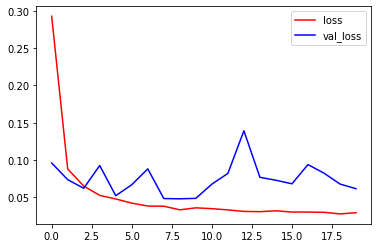

In [18]:
plt.plot(range(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(range(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

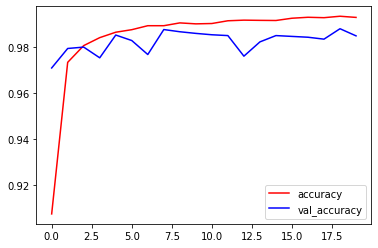

In [19]:
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='accuracy')
plt.plot(np.arange(len(res.history['val_accuracy'])), res.history['val_accuracy'], c='blue', label='val_accuracy')
plt.legend()
plt.show()

## prediciton

In [20]:
pred=model.predict(X_test_cnn)

In [21]:
pred_list=[]
for arr in pred:
    pred_list.append(np.argmax(arr))

In [22]:
pred_s=pd.Series(pred_list)
sub['Label']=pred_s

In [23]:
sub.to_csv('/content/gdrive/MyDrive/digit_k/dataset/sub_v07_fds.csv', index=False)

# Full dataset training

In [ ]:
input_shape = (28,28,1)
num_class = 10

model = Sequential([Conv2D(32, kernel_size = (6,6), input_shape = input_shape, activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Conv2D(32, kernel_size = (4,4), input_shape = input_shape, activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                    MaxPooling2D(pool_size = (2,2)),
                    Flatten(),
                    Dense(32, activation = 'relu'),
                    Dense(10, activation = 'softmax')
                    ])

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = 'accuracy')

In [ ]:
X_aug = np.concatenate((X_train_cnn, X_val_cnn))
y_aug = np.concatenate((y_train_arr_train, y_train_arr_val))
X_aug.shape, y_aug.shape

((42000, 28, 28, 1), (42000, 10))

In [ ]:
batch_size = 20

# train Augmentation Setting
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   validation_split = 0.2)

# train Augmentation
train_generator = train_datagen.flow(X_train_cnn, y_train_arr_train,  
                                     batch_size = batch_size,
                                     subset = 'training')


val_generator = train_datagen.flow(X_train_cnn, y_train_arr_train,  
                                 batch_size = batch_size,
                                 subset = 'validation')


# validation Augmentation Setting
test_datagen = ImageDataGenerator()

# validation Augmentation
test_generator = test_datagen.flow(X_val_cnn, y_train_arr_val,  
                                    batch_size = batch_size) 


In [ ]:
res = model.fit(train_generator,
                steps_per_epoch = len(X_train_cnn)*0.8/batch_size,
                epochs = 20,
                validation_data = val_generator,
                validation_steps = len(X_train_cnn)*0.2/batch_size
                )

Epoch 1/20
1520/1520 [==============================] - 36s 23ms/step - loss: 0.3586 - accuracy: 0.8845 - val_loss: 0.1235 - val_accuracy: 0.9614
Epoch 2/20
1520/1520 [==============================] - 34s 22ms/step - loss: 0.0956 - accuracy: 0.9709 - val_loss: 0.0773 - val_accuracy: 0.9747
Epoch 3/20
1520/1520 [==============================] - 34s 23ms/step - loss: 0.0680 - accuracy: 0.9787 - val_loss: 0.0861 - val_accuracy: 0.9738
Epoch 4/20
1520/1520 [==============================] - 34s 23ms/step - loss: 0.0546 - accuracy: 0.9839 - val_loss: 0.0812 - val_accuracy: 0.9787
Epoch 5/20
1520/1520 [==============================] - 34s 22ms/step - loss: 0.0476 - accuracy: 0.9859 - val_loss: 0.0531 - val_accuracy: 0.9851
Epoch 6/20
1520/1520 [==============================] - 35s 23ms/step - loss: 0.0425 - accuracy: 0.9878 - val_loss: 0.0502 - val_accuracy: 0.9864
Epoch 7/20
1520/1520 [==============================] - 35s 23ms/step - loss: 0.0396 - accuracy: 0.9894 - val_loss: 0.0527 -

In [ ]:
loss, accuracy = model.evaluate(X_val_cnn, y_train_arr_val)
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

125/125 [==============================] - 1s 8ms/step - loss: 0.0739 - accuracy: 0.9905
Loss = 0.07390
Accuracy = 0.99050


## Check overfitting

In [ ]:
# res.history

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


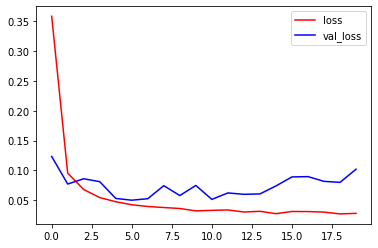

In [ ]:
plt.plot(range(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(range(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

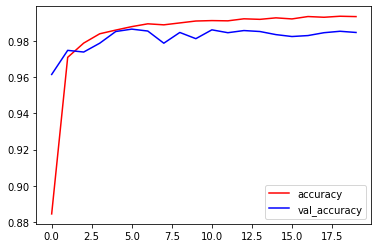

In [ ]:
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='accuracy')
plt.plot(np.arange(len(res.history['val_accuracy'])), res.history['val_accuracy'], c='blue', label='val_accuracy')
plt.legend()
plt.show()

## prediciton

In [ ]:
pred=model.predict(X_test_cnn)

In [ ]:
pred_list=[]
for arr in pred:
    pred_list.append(np.argmax(arr))

In [ ]:
pred_s=pd.Series(pred_list)
sub['Label']=pred_s

In [ ]:
# sub.to_csv('/content/gdrive/MyDrive/digit_k/dataset/sub_v06_aug.csv', index=False)